In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import graph_tool.all as gt
from graph_tool import topology
import itertools
import community


## Question 1a


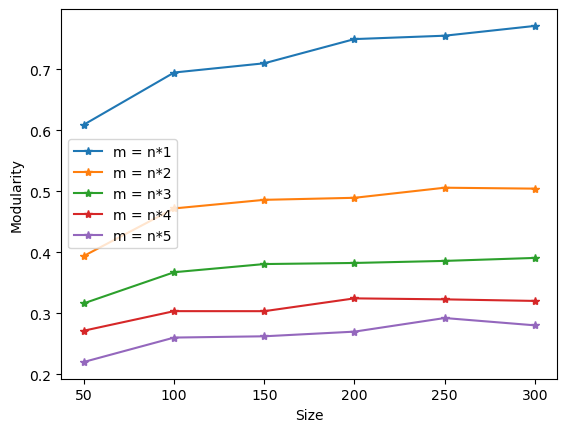

In [4]:
#Replicating Figure 2 from Guimera, Sales-Pardo, and Amaral, 2004
fig, ax = plt.subplots(1,1)


#setting network sizes
sizes = [x for x in range(50,301,50)]

comm_num_dict = {size:None for size in sizes} #not needed
modularity_dict = {size:None for size in sizes}

for n in sizes:
    m_s = [n*x for x in range(1,6)]
    num_communities_n = []
    modularity_n = []
    for m in m_s:
        G = nx.gnm_random_graph(n,m)
        partition = community.best_partition(G)
        num_communities = len(set(partition.values()))
        num_communities_n.append(num_communities)
        modularity = community.modularity(partition,G)
        modularity_n.append(modularity)

    comm_num_dict[n]=num_communities_n
    modularity_dict[n]=modularity_n

Q_df = pd.DataFrame(modularity_dict).T

m = ['n','n*2','n*3','n*4','n*5']

for line_num in range(5):
    ax.plot(Q_df[line_num],marker='*',label=f"m = n*{line_num+1}")
    line_num +=1

ax.set_ylabel("Modularity")
ax.set_xlabel("Size")
ax.set_xticks(sizes)
ax.legend()

## Question 1b

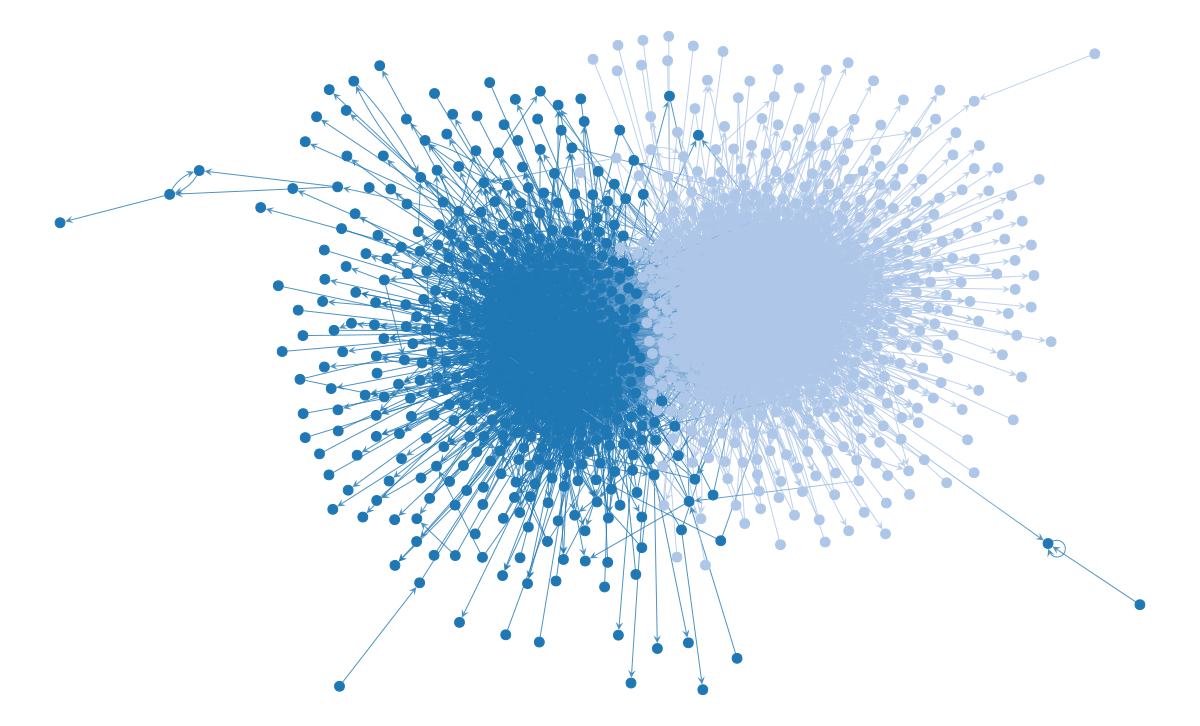

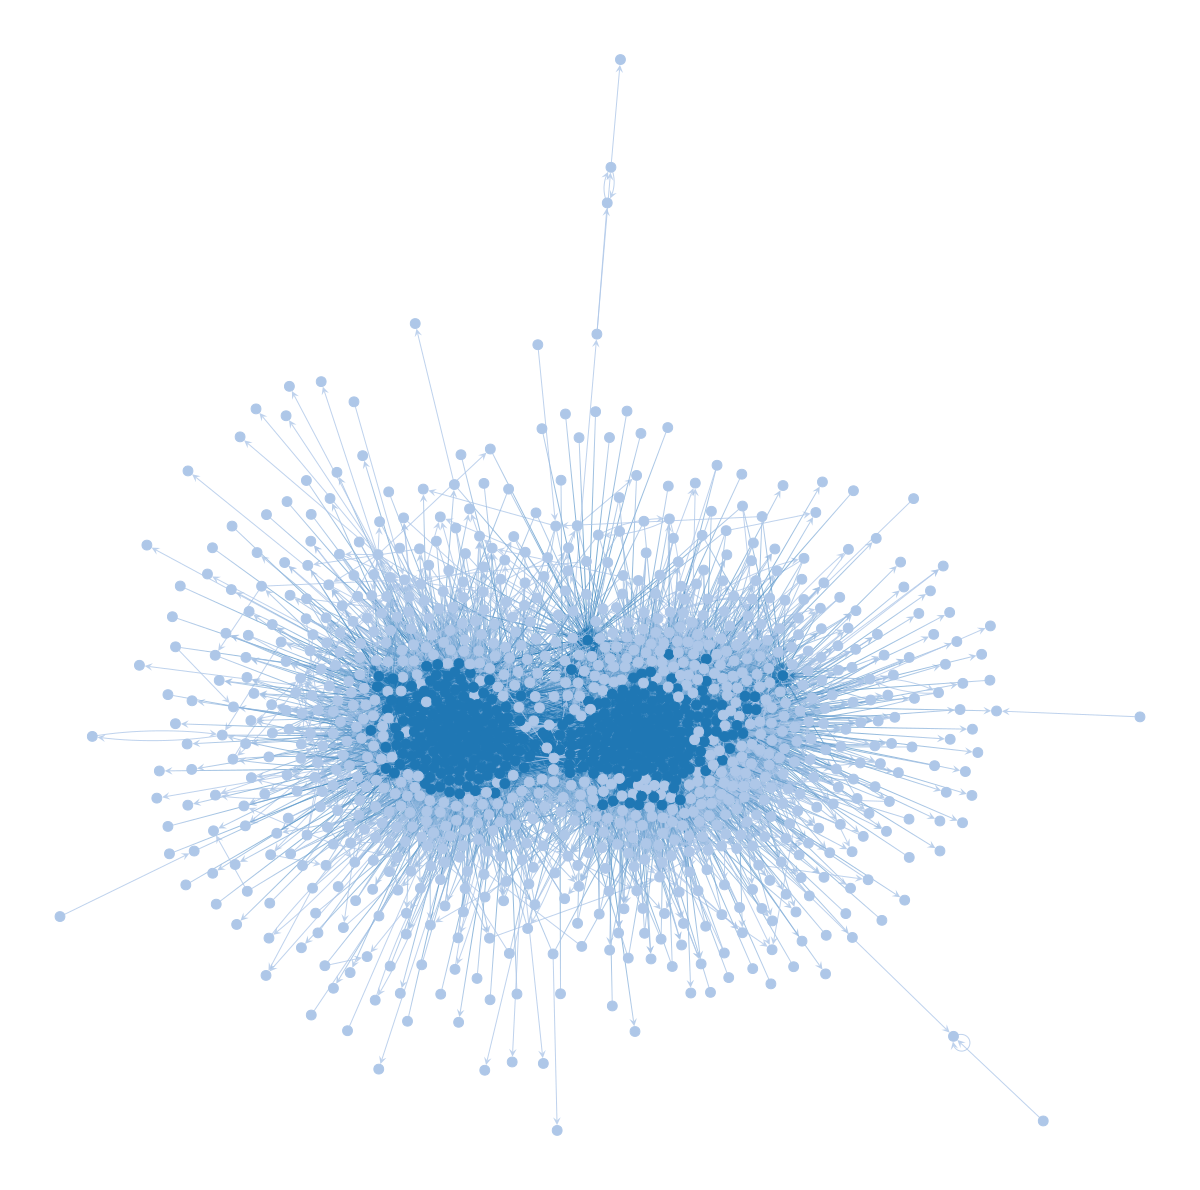

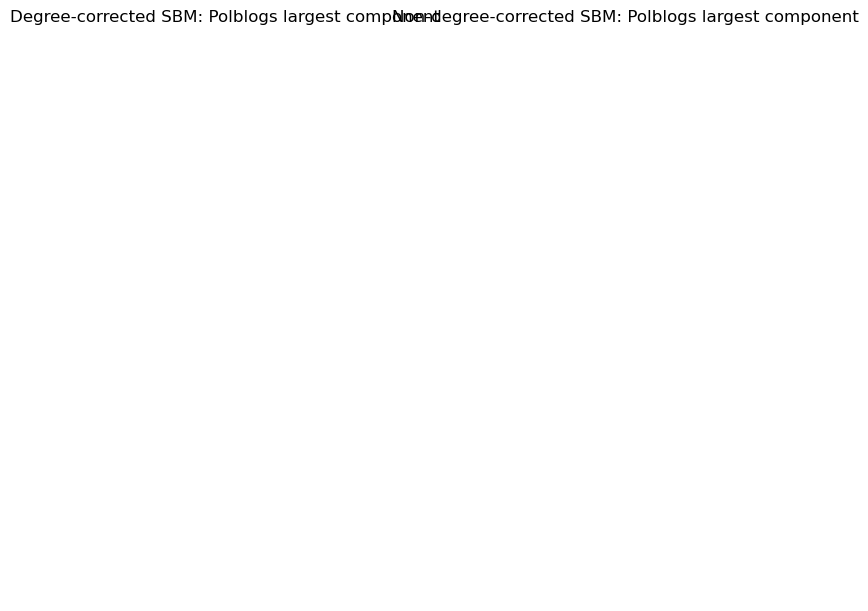

In [23]:
fig ,ax = plt.subplots(1,2,figsize=(8,6),constrained_layout=True)

#loading data
G_0=gt.collection.ns["polblogs"]

#getting largest component
G = topology.extract_largest_component(G_0,directed=False)

#fitting blockmodel
state_dc = gt.minimize_blockmodel_dl(G,state_args=dict(deg_corr=True),multilevel_mcmc_args={'B_max':2})

state_no_dc = gt.minimize_blockmodel_dl(G,state_args=dict(deg_corr=False),multilevel_mcmc_args={'B_max':2})

#visualizing
state_dc.draw(ax=ax[0])
state_no_dc.draw(ax=ax[1])

ax[0].set_title('Degree-corrected SBM: Polblogs largest component')
ax[1].set_title('Non-degree-corrected SBM: Polblogs largest component')
ax[0].set_axis_off()
ax[1].set_axis_off()


plt.show()


## Question 1c

Description length of degree-corrected model: 61739.197677562566
Description length of non-degree-corrected model: 64509.15318383654


Text(0.5, 0, 'MCMC Iterations')

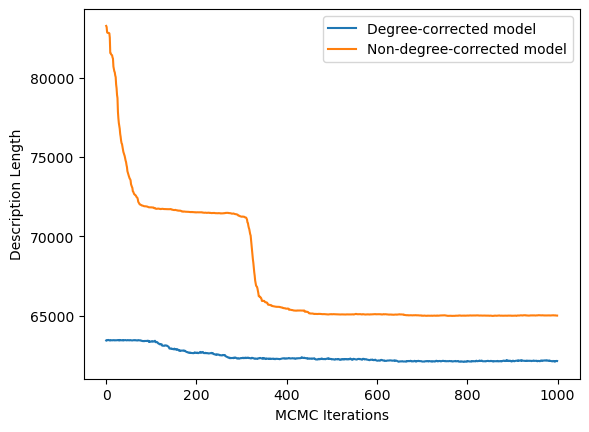

In [239]:

#get state entropies
print(f"Description length of degree-corrected model: {state_dc.entropy()}")
print(f"Description length of non-degree-corrected model: {state_no_dc.entropy()}")


#get description lengths for 1000 iterations of mcmc algorithm
dc_dls = []

state_dc = gt.minimize_blockmodel_dl(G,state_args=dict(deg_corr=True),multilevel_mcmc_args={'B_max':2})

for i in range(1000):
    state_dc.mcmc_sweep(niter=1)
    dl = state_dc.entropy()
    dc_dls.append(dl)



no_dc_dls = []

state_no_dc = gt.minimize_blockmodel_dl(G,state_args=dict(deg_corr=False),multilevel_mcmc_args={'B_max':2})

for i in range(1000):
    state_no_dc.mcmc_sweep(niter=1)
    dl = state_no_dc.entropy()
    no_dc_dls.append(dl)


#plot

fig,ax = plt.subplots(1,1)

ax.plot(dc_dls,label="Degree-corrected model")
ax.plot(no_dc_dls,label="Non-degree-corrected model")
ax.legend()
ax.set_ylabel("Description Length")
ax.set_xlabel("MCMC Iterations")

## Question 2c

## Question 3a

In [7]:
#function that computes commute time of a random walker 

def commute_time(G,start,end):
    """
    Computed the commute time of a single random walker between nodes i and j in a network.

    Parameters:
    --------------
    G: networkx.Graph
        Network
    start: node
        Node i in network
    end: node
        Node j in network

    Returns:
    -------------
    commute_time (int):
        Time it takes random walker to get from node i to node j

    Example:
    -------------
    >>> commute_time(G, 4, 90)
    35
    
    """

    #start path list
    path = [start]

    current_node = start

    while current_node != end:
        neighbors = list(G.neighbors(current_node))
        if neighbors:
            next_node = np.random.choice(neighbors)
            path.append(next_node)
            current_node=next_node
        else:
            break

    commute_time = len(path)

    return commute_time


In [30]:
G = nx.karate_club_graph()
nodes = list(G.nodes())

for i in range(3):
    start = np.random.choice(nodes)
    end = np.random.choice(nodes)

    ct = commute_time(G,start,end)
    print(f"Commute time between node {start} and node {end} is {ct}.")


Commute time between node 19 and node 17 is 334.
Commute time between node 0 and node 1 is 146.
Commute time between node 10 and node 4 is 34.


## Question 3b

In [13]:
#Writing a function to calculate mean commute time within networks

def mean_commute(G):
    """

    Parameters:
    --------------
    G: networkx.Graph
        Network

    Returns:
    -------------
    mean_commute (float):
        Time it takes random walker to get from node i to node j

    Example:
    -------------
    >>> mean_commute(G)
    34.2


    """

    nodes = list(G.nodes())

    #get all pairs of nodes

    node_pairs = list(itertools.combinations(nodes,2))

    commutes = []

    #get all commute times

    for pair in node_pairs:
        start = pair[0]
        end = pair[1]
        commute = commute_time(G,start,end)
        commutes.append(commute)

    #get mean
    mean_commute = np.mean(commutes)

    return mean_commute
        

In [17]:
#Calculating mean commute time for Erdos-Renyi network with N = 500 and ⟨k⟩ = 8
N = 100
k_avg = 8
p = 8/(N-1)
G_ER = nx.erdos_renyi_graph(N,p)

mean_commute_ER = mean_commute(G_ER)

print(f"Mean commute time for an Erdos-Renyi network with N = {N} and ⟨k⟩ = {k_avg} is {mean_commute_ER}")

#Get average across 10 samples

commutes = []
for i in range(10):
    G_ER = nx.erdos_renyi_graph(N,p)
    mean_commute_ER = mean_commute(G_ER)
    commutes.append(mean_commute_ER)
commutes10 = np.mean(commutes)

print(f"Mean commute time across 10 samples: {commutes10}")
    
    


Mean commute time for an Erdos-Renyi network with N = 100 and ⟨k⟩ = 8 is 130.68161616161615
Mean commute time across 10 samples: 132.9420202020202


In [19]:
#Calculating mean commute time for Barabasi-Albert networks with N = 100 and m = 4
N = 100
m = 4

G_BA = nx.barabasi_albert_graph(N,m)

mean_commute_BA = mean_commute(G_BA)

print(f"Mean commute time for a Barabasi-Albert network with N = {N} and m = {m} is {mean_commute_BA}")

commutes = []
for i in range(10):
    G_BA = nx.barabasi_albert_graph(N,m)
    mean_commute_BA = mean_commute(G_BA)
    commutes.append(mean_commute_BA)
commutes10 = np.mean(commutes)

print(f"Mean commute time across 10 samples: {commutes10}")

Mean commute time for a Barabasi-Albert network with N = 100 and m = 4 is 177.61111111111111
Mean commute time across 10 samples: 180.34484848484848
